In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [41]:
# Code paths 
sys.path.append('../Models')
import Sarima

In [42]:
Data_train = pd.read_csv(
    "../Data/train.csv",
    parse_dates=["Date"]
)

Data_test = pd.read_csv(
    "../Data/test.csv",
    parse_dates=["Date"]
)

In [43]:
Data_train.head()

,Date,Load,Load.1,Load.7,Net_demand,Solar_power,Wind_power,Temp,Temp_s95,Temp_s99,...,Holiday_zone_a,Holiday_zone_b,Holiday_zone_c,BH_Holiday,Solar_power.1,Solar_power.7,Wind_power.1,Wind_power.7,Net_demand.1,Net_demand.7
0,2013-03-02,69902.979167,76353.208333,78166.125000,68453.000000,398.854167,1051.125000,276.243539,276.528356,275.983263,...,1,1,1,11,398.854167,398.854167,1051.125000,1051.125000,68453.000000,68453.000000
1,2013-03-03,64929.250000,69902.979167,75368.020833,63047.895833,633.291667,1248.062500,276.945418,276.480771,276.092675,...,1,1,1,11,398.854167,633.291667,1051.125000,1248.062500,68453.000000,63047.895833
2,2013-03-04,69275.437500,64929.250000,80191.604167,65816.041667,651.687500,2807.708333,280.044604,278.478491,276.868222,...,1,0,1,1,633.291667,651.687500,1248.062500,2807.708333,63047.895833,65816.041667
3,2013-03-05,66720.000000,69275.437500,79539.187500,63442.854167,285.729167,2991.416667,282.979150,282.078125,278.864944,...,1,0,1,1,651.687500,285.729167,2807.708333,2991.416667,65816.041667,63442.854167
4,2013-03-06,64401.166667,66720.000000,78255.416667,62736.583333,210.541667,1454.041667,283.428551,283.405606,280.646612,...,1,0,1,1,285.729167,210.541667,2991.416667,1454.041667,63442.854167,62736.583333


# This part has to be removed and put in sarima.py to make it more clear 

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [45]:
%pip install pmdarima


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [46]:
Data_train.set_index('Date', inplace=True)
Data_test.set_index('Date', inplace=True)
Data_test.head()


,Load.1,Load.7,Temp,Temp_s95,Temp_s99,Temp_s95_min,Temp_s95_max,Temp_s99_min,Temp_s99_max,Wind,...,Holiday_zone_c,BH_Holiday,Solar_power.1,Solar_power.7,Wind_power.1,Wind_power.7,Net_demand.1,Net_demand.7,Id,Usage
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-02,45411.416667,44225.645833,293.273565,294.026968,294.756084,292.996480,295.329880,294.527443,295.212562,2.583681,...,0,0,2821.625000,2696.375000,2280.229167,2797.791667,40309.562500,38731.479167,1,Private
2022-09-03,44505.208333,39762.375000,293.250733,293.286898,294.159741,291.947908,294.585350,293.929403,294.491779,2.899471,...,0,10,2192.187500,3058.000000,1716.041667,2362.083333,40596.979167,34342.291667,2,Private
2022-09-04,39659.083333,37743.625000,294.962899,294.042208,294.005398,291.398531,296.747642,293.442619,294.601080,2.883795,...,0,10,2300.708333,3310.625000,1862.041667,3594.791667,35496.333333,30838.208333,3,Private
2022-09-05,38288.187500,44106.250000,295.767886,295.711570,294.691920,293.813071,297.555803,294.204077,295.205786,3.176540,...,0,0,3034.479167,2694.500000,2340.520833,3826.958333,32913.187500,37584.791667,4,Public
2022-09-06,44780.416667,45844.604167,294.650971,295.053978,294.877428,293.472748,296.440169,294.533256,295.172523,3.176417,...,0,0,2892.833333,2681.666667,3396.375000,2671.770833,38491.208333,40491.166667,5,Private


In [47]:
weekday_dummies = pd.get_dummies(Data_train['WeekDays'], prefix='day', drop_first=True)


# Join them back and drop the original quantitative 'WeekDays'
Data_train = pd.concat([Data_train, weekday_dummies], axis=1)
Data_train.drop('WeekDays', axis=1, inplace=True)


weekday_dummies = pd.get_dummies(Data_test['WeekDays'], prefix='day', drop_first=True)
Data_test = pd.concat([Data_test, weekday_dummies], axis=1)
Data_test.drop('WeekDays', axis=1, inplace=True)

Data_train.head()
Data_test.head()

,Load.1,Load.7,Temp,Temp_s95,Temp_s99,Temp_s95_min,Temp_s95_max,Temp_s99_min,Temp_s99_max,Wind,...,Net_demand.1,Net_demand.7,Id,Usage,day_1,day_2,day_3,day_4,day_5,day_6
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-02,45411.416667,44225.645833,293.273565,294.026968,294.756084,292.996480,295.329880,294.527443,295.212562,2.583681,...,40309.562500,38731.479167,1,Private,False,False,False,True,False,False
2022-09-03,44505.208333,39762.375000,293.250733,293.286898,294.159741,291.947908,294.585350,293.929403,294.491779,2.899471,...,40596.979167,34342.291667,2,Private,False,False,False,False,True,False
2022-09-04,39659.083333,37743.625000,294.962899,294.042208,294.005398,291.398531,296.747642,293.442619,294.601080,2.883795,...,35496.333333,30838.208333,3,Private,False,False,False,False,False,True
2022-09-05,38288.187500,44106.250000,295.767886,295.711570,294.691920,293.813071,297.555803,294.204077,295.205786,3.176540,...,32913.187500,37584.791667,4,Public,False,False,False,False,False,False
2022-09-06,44780.416667,45844.604167,294.650971,295.053978,294.877428,293.472748,296.440169,294.533256,295.172523,3.176417,...,38491.208333,40491.166667,5,Private,True,False,False,False,False,False


In [48]:
exog_cols = ['Temp', 'Holiday', 'toy']#, 'Net_demand.1', 'Net_demand.7']#, 'Load.1','Solar_power.1','Wind_power.1', "day_1", "day_2", "day_3", "day_4", "day_5", "day_6",] #,'Wind_power.7', 'Load.7', ,'Solar_power.7']

In [49]:
train_x = Data_train[exog_cols]
train_y = Data_train["Net_demand"]

test_x = Data_test[exog_cols]
test_y_1 = Data_test["Net_demand.1"]
test_y_1

Date
2022-09-02    40309.562500
2022-09-03    40596.979167
2022-09-04    35496.333333
2022-09-05    32913.187500
2022-09-06    38491.208333
                  ...     
2023-09-27    38360.770833
2023-09-28    37836.500000
2023-09-29    37951.000000
2023-09-30    34614.125000
2023-10-01    34625.437500
Name: Net_demand.1, Length: 395, dtype: float64

In [50]:
test_x

,Temp,Holiday,toy
Date,,,
2022-09-02,293.273565,0,0.669
2022-09-03,293.250733,0,0.672
2022-09-04,294.962899,0,0.675
2022-09-05,295.767886,0,0.678
2022-09-06,294.650971,0,0.680
...,...,...,...
2023-09-27,291.997460,0,0.738
2023-09-28,292.491451,0,0.740
2023-09-29,292.042287,0,0.743


In [51]:
import pmdarima as pm


In [52]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Sarimax

In [53]:
# Fit the model on training data
model = SARIMAX(train_y, exog=train_x, order=(p,d,q), seasonal_order=(P,D,Q,7))
results = model.fit(disp=False)

/home/volodya-ubuntu24/git-folders/Net-Load-Forecasting-During-the-Soberty-Period/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/volodya-ubuntu24/git-folders/Net-Load-Forecasting-During-the-Soberty-Period/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/volodya-ubuntu24/git-folders/Net-Load-Forecasting-During-the-Soberty-Period/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
for i in range (len(test_x)):
    print(test_x.iloc[[i]])

                  Temp  Holiday    toy
Date                                  
2022-09-02  293.273565        0  0.669
                  Temp  Holiday    toy
Date                                  
2022-09-03  293.250733        0  0.672
                  Temp  Holiday    toy
Date                                  
2022-09-04  294.962899        0  0.675
                  Temp  Holiday    toy
Date                                  
2022-09-05  295.767886        0  0.678
                  Temp  Holiday   toy
Date                                 
2022-09-06  294.650971        0  0.68
                  Temp  Holiday    toy
Date                                  
2022-09-07  292.650627        0  0.683
                  Temp  Holiday    toy
Date                                  
2022-09-08  291.605477        0  0.686
                  Temp  Holiday    toy
Date                                  
2022-09-09  291.014468        0  0.689
                  Temp  Holiday    toy
Date                        

In [60]:
obs = test_x.iloc[[1]]
pd.Series([test_y_1.iloc[1]], index=obs.index), obs

(Date
 2022-09-03    40596.979167
 dtype: float64,
                   Temp  Holiday    toy
 Date                                  
 2022-09-03  293.250733        0  0.672)

In [58]:
# 2. Iterate through the test set row by row
predictions = []
current_model = results

obs_exog = test_x.iloc[[0]]
one_step_forecast = current_model.forecast(steps=1, exog=obs_exog)
predictions.append(one_step_forecast.iloc[0])

for i in range(1, len(test_x)):
    obs_exog = test_x.iloc[[i]]

    new_y = pd.Series([test_y_1.iloc[i]], index=obs_exog.index)
    current_model = current_model.extend(new_y, exog=obs_exog)

    # Predict ONLY the next day
    one_step_forecast = current_model.forecast(steps=1, exog=obs_exog)
    predictions.append(one_step_forecast.iloc[0])
    
    # UPDATE the model with the real data point you just "discovered"


ValueError: Given `endog` does not have an index that extends the index of the model. Expected index frequency is "<Day>", but got "None".

In [ ]:
exog_cols = ['Temp', 'Holiday', 'toy', 'Load.1','Solar_power.1','Wind_power.1', "day_1", "day_2", "day_3", "day_4", "day_5", "day_6"] #,'Wind_power.7', 'Load.7', ,'Solar_power.7']

train_x = Data_train[exog_cols]
train_y = Data_train["Net_demand"]

test_x = Data_test[exog_cols]
test_y_1 = Data_test["Net_demand.1"]
test_y_1

Date
2022-09-02    40309.562500
2022-09-03    40596.979167
2022-09-04    35496.333333
2022-09-05    32913.187500
2022-09-06    38491.208333
                  ...     
2023-09-27    38360.770833
2023-09-28    37836.500000
2023-09-29    37951.000000
2023-09-30    34614.125000
2023-10-01    34625.437500
Name: Net_demand.1, Length: 395, dtype: float64

In [94]:
model_2 = SARIMAX(train_y, exog=train_x, order=(p,d,q), seasonal_order=(P,D,Q,7))
results_2 = model_2.fit(disp=False)

/home/volodya-ubuntu24/git-folders/Net-Load-Forecasting-During-the-Soberty-Period/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/volodya-ubuntu24/git-folders/Net-Load-Forecasting-During-the-Soberty-Period/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [86]:
final_predictions_2 = results_2.predict(start=test_x.index[0], 
                                    end=test_x.index[-1], 
                                    exog=test_x)

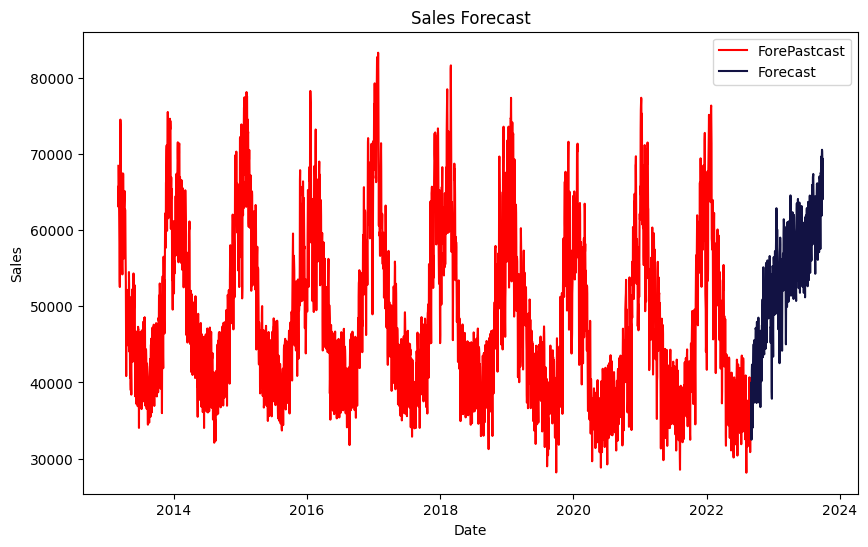

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(train_y, label='ForePastcast', color='red')
plt.plot(final_predictions_2, label='Forecast', color='#121243')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [ ]:
#model = pm.auto_arima(train_y, 
#                   exogenous=train_x,
#                   m=7, 
#                   seasonal=True,
#                   stepwise=True)

In [ ]:

# 3. Predict using test exogenous data
#forecast = model.predict(n_periods=len(test_x), 
#                         exogenous=test_x)

In [ ]:
#forecast

2022-09-02    39602.888124
2022-09-03    37418.791519
2022-09-04    35950.562344
2022-09-05    40053.256626
2022-09-06    41881.906591
                  ...     
2033-03-29    44948.119370
2033-03-30    44948.119370
2033-03-31    44948.119370
2033-04-01    44948.119370
2033-04-02    44948.119370
Freq: D, Length: 3866, dtype: float64

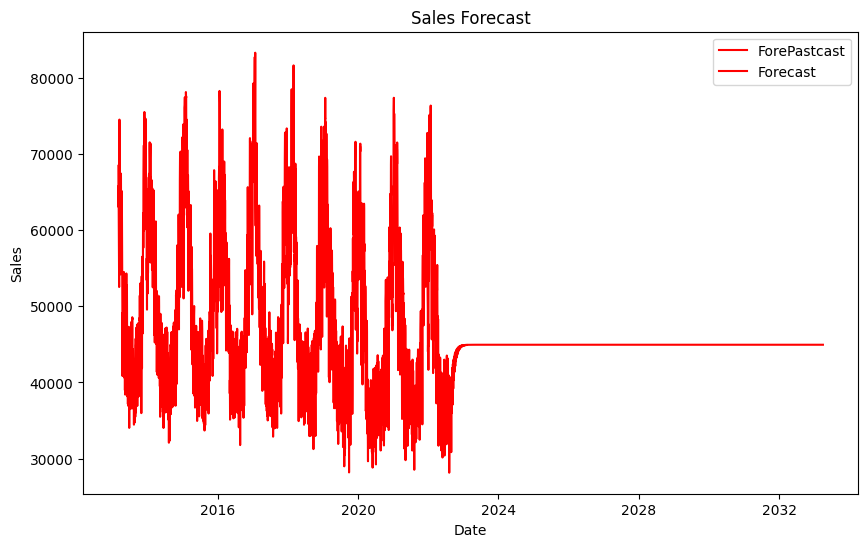

In [ ]:
"""
plt.figure(figsize=(10, 6))
plt.plot(train_y, label='ForePastcast', color='red')
plt.plot(forecast, label='Forecast', color='red')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
"""

In [48]:
def submit_predictions(ids, predictions, filename = None):
    """
    create a submission file if the file does not exist or just overwrite it
    """
    submission_df = pd.DataFrame({
        "Id": ids,
        "Net_demand": predictions
    })
    if filename is None:
        filename = "submission"
    filename = filename + ".csv"

    filepath = "../Results/" + filename

    if os.path.exists(filepath):
        print(f"File {filename} already exists. Overwriting...")
    else:
        print(f"Creating submission file {filename}...")

    submission_df.to_csv(filepath, index=False)
    print(f"Submission file {filename} created.")

In [49]:
results_df = pd.DataFrame({
    'Net_demand': forecast
})
#Data_test["Id"]
#results_df = results_df.reset_index()#.drop("index")
submit_predictions(Data_test["Id"], np.array(results_df["Net_demand"]), filename = "Arima_7_3params")


File Arima_7_3params.csv already exists. Overwriting...
Submission file Arima_7_3params.csv created.


In [39]:
results_df
Data_test

,Load.1,Load.7,Temp,Temp_s95,Temp_s99,Temp_s95_min,Temp_s95_max,Temp_s99_min,Temp_s99_max,Wind,...,Net_demand.1,Net_demand.7,Id,Usage,day_1,day_2,day_3,day_4,day_5,day_6
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,True,False
2013-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,True
2013-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2013-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,False,False,False,False,False
2013-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-27,43408.354167,43552.062500,291.997460,291.435823,290.222493,288.958733,293.691268,289.607889,290.947961,2.821125,...,38360.770833,33123.416667,391.0,Private,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,43708.583333,43582.312500,292.491451,292.440362,291.106861,290.752016,293.950043,290.658545,291.627601,2.649681,...,37836.500000,35759.833333,392.0,Private,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-29,43708.604167,42183.354167,292.042287,292.530520,291.697804,291.566430,293.548410,291.427708,291.997395,3.522810,...,37951.000000,33062.541667,393.0,Private,NaN,NaN,NaN,NaN,NaN,NaN
